# 0. GPU 확인

In [1]:
from tensorflow.python.client import device_lib
device_lib.list_local_devices()

[name: "/device:CPU:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 1789696384603839064
 xla_global_id: -1,
 name: "/device:GPU:0"
 device_type: "GPU"
 memory_limit: 6267797504
 locality {
   bus_id: 1
   links {
   }
 }
 incarnation: 9704122036976682585
 physical_device_desc: "device: 0, name: NVIDIA GeForce RTX 2070 SUPER, pci bus id: 0000:01:00.0, compute capability: 7.5"
 xla_global_id: 416903419]

# 1. Create Dataset

In [2]:
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
import os
import glob
import random
import cv2

## 1.1. data path

In [3]:
test_data_path = './data/test_data'
test_image_paths = glob.glob(os.path.join(test_data_path, '*'))
test_image_paths

['./data/test_data\\DSCF1859.JPG',
 './data/test_data\\DSCF1880.JPG',
 './data/test_data\\ILSVRC2012_val_00000070.JPEG',
 './data/test_data\\ILSVRC2012_val_00000546.JPEG',
 './data/test_data\\ILSVRC2012_val_00000846.JPEG',
 './data/test_data\\ILSVRC2012_val_00000979.JPEG',
 './data/test_data\\ILSVRC2012_val_00001320.JPEG',
 './data/test_data\\ILSVRC2012_val_00001340.JPEG',
 './data/test_data\\ILSVRC2012_val_00002213.JPEG',
 './data/test_data\\ILSVRC2012_val_00002543.JPEG',
 './data/test_data\\ILSVRC2012_val_00003648.JPEG',
 './data/test_data\\ILSVRC2012_val_00003946.JPEG',
 './data/test_data\\ILSVRC2012_val_00004338.JPEG',
 './data/test_data\\ILSVRC2012_val_00004405.JPEG',
 './data/test_data\\ILSVRC2012_val_00004806.JPEG',
 './data/test_data\\ILSVRC2012_val_00004833.JPEG',
 './data/test_data\\ILSVRC2012_val_00005584.JPEG',
 './data/test_data\\ILSVRC2012_val_00006118.JPEG',
 './data/test_data\\ILSVRC2012_val_00006436.JPEG',
 './data/test_data\\ILSVRC2012_val_00006617.JPEG',
 './data/tes

## 1.2. Custom Dataset Class

In [4]:
class Custom_Image_Dataset(Dataset) :
    
    def __init__(self, image_paths, transforms=None):
        self.image_paths = image_paths
        self.transforms = transforms
        
    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img = cv2.imread(self.image_paths[idx])
        
        x = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)/256
        y = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)/256
        
        if self.transforms is not None :
            x = self.transforms(x).float()
            y = self.transforms(y).float()
        
        return x, y

## 1.3. Data Load

In [5]:
transform = transforms.Compose([
    transforms.ToTensor()
])

In [6]:
test_dataset = Custom_Image_Dataset(test_image_paths, transform)
test_dataloader = DataLoader(test_dataset, batch_size = 4, shuffle = False)

# 2. Load Model

In [7]:
import torch
import torch.nn as nn

In [8]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

## 2.1. define model function

In [9]:
class UNET(nn.Module) :
    def __init__(self) :
        super().__init__()
        
        def conv(in_dim, out_dim) :
            model = nn.Sequential(
                nn.Conv2d(in_dim, out_dim, kernel_size=3, padding='same'),
                nn.BatchNorm2d(out_dim),
                nn.ReLU(inplace=True),
                nn.Conv2d(out_dim, out_dim, kernel_size=3, padding='same'),
                nn.BatchNorm2d(out_dim),
                nn.ReLU(inplace=True)
            )
            return model
        
        def max_pool() :
            model = nn.MaxPool2d(2)
            return model
        
        def up_conv(in_dim, out_dim) :
            model = nn.Sequential(
                nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True),
                nn.Conv2d(in_dim, out_dim, kernel_size=2, padding='same')
            )
            return model
        
        self.input = nn.Sequential()
        self.enc1 = conv(1, 64)
        self.enc2 = nn.Sequential(max_pool(), conv(64, 128))
        self.enc3 = nn.Sequential(max_pool(), conv(128, 256))
        self.enc4 = nn.Sequential(max_pool(), conv(256, 512))
        self.enc5 = nn.Sequential(max_pool(), conv(512, 1024))
        
        self.dec1 = up_conv(1024, 512)
        self.dec2 = nn.Sequential(conv(1024, 512), up_conv(512, 256))
        self.dec3 = nn.Sequential(conv(512, 256), up_conv(256, 128))
        self.dec4 = nn.Sequential(conv(256, 128), up_conv(128, 64))
        self.dec5 = conv(128, 64)
        self.out = nn.Conv2d(64, 3, kernel_size=1, padding = 'same')
        
        
        
    def forward(self, x):
        x = self.input(x)
        x1 = self.enc1(x)
        x2 = self.enc2(x1)
        x3 = self.enc3(x2)
        x4 = self.enc4(x3)
        x5 = self.enc5(x4)
        
        x = self.dec1(x5)
        x = torch.cat([x, x4], dim = 1)
        x = self.dec2(x)
        x = torch.cat([x, x3], dim = 1)
        x = self.dec3(x)
        x = torch.cat([x, x2], dim = 1)
        x = self.dec4(x)
        x = torch.cat([x, x1], dim = 1)
        x = self.dec5(x)
        x = self.out(x)
        
        
        return x

## 2.2. model compile

In [10]:
trained_model_UNET = UNET().to(device)

## 2.3. load trained state dict path

In [11]:
trained_state_dict_path = './data/model_saved/checkpoint_UNET_RGB.pt'

## 2.3. load saved model 

In [12]:
trained_model_UNET.load_state_dict(torch.load(trained_state_dict_path, map_location=device))

<All keys matched successfully>

# 3. Test

In [13]:
import numpy as np
from tqdm.notebook import tqdm

## 3.1. test function

In [14]:
def test_model(model, test_dataloader) :
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    
    test_data_list = []
    test_output_list = []
    test_target_list = []
    model.eval()
    
    test_dataloader_tqdm = tqdm(test_dataloader, desc="Test  ")
    for test_data, test_target in test_dataloader_tqdm :
        test_data = test_data.to(device)
        test_target = test_target.to(device)
        
        test_output = model(test_data)
        
        test_data_list.append(test_data.cpu().detach().numpy())
        test_output_list.append(test_output.cpu().detach().numpy())
        test_target_list.append(test_target.cpu().detach().numpy())
        
        del test_data
        del test_target
        del test_output
        torch.cuda.empty_cache()
    
    x = np.concatenate(test_data_list, axis = 0)
    y_predicted = np.concatenate(test_output_list, axis = 0)
    y_real = np.concatenate(test_target_list, axis = 0)
    
    torch.cuda.empty_cache()
    
    return x, y_predicted, y_real

## 3.2. predict

In [15]:
x_test, y_test_predicted, y_test_real = test_model(trained_model_UNET, test_dataloader)

Test  :   0%|          | 0/25 [00:00<?, ?it/s]

C:\Users\T921\anaconda3\lib\site-packages\torch\nn\modules\conv.py:442: UserWarning: Using padding='same' with even kernel lengths and odd dilation may require a zero-padded copy of the input be created (Triggered internally at  ..\aten\src\ATen\native\Convolution.cpp:647.)
  return F.conv2d(input, weight, bias, self.stride,


In [16]:
y_test_predicted.shape

(100, 3, 128, 128)

In [17]:
y_test_predicted

array([[[[ 9.80256081e-01,  1.01048899e+00,  1.00033855e+00, ...,
           9.97260869e-01,  1.00536227e+00,  9.88988101e-01],
         [ 1.00270331e+00,  1.01399112e+00,  1.00534916e+00, ...,
           9.97768939e-01,  1.01240480e+00,  1.01176190e+00],
         [ 9.91041362e-01,  1.00727582e+00,  1.01259089e+00, ...,
           9.98710334e-01,  1.01364207e+00,  1.00209951e+00],
         ...,
         [ 9.87141609e-01,  9.95693564e-01,  9.96708274e-01, ...,
           9.78828430e-01,  9.81985450e-01,  9.88507330e-01],
         [ 9.91217077e-01,  9.99904394e-01,  1.00219512e+00, ...,
           9.95128751e-01,  9.83458996e-01,  9.96355057e-01],
         [ 9.76809263e-01,  9.95257080e-01,  9.90036905e-01, ...,
           9.96204913e-01,  9.94513512e-01,  9.63860631e-01]],

        [[ 9.83021438e-01,  1.00383794e+00,  9.92346406e-01, ...,
           9.91594017e-01,  1.00189328e+00,  9.94652748e-01],
         [ 9.96537566e-01,  1.00972295e+00,  9.97026682e-01, ...,
           9.92614925e

## 3.3. 채널 위치 변경

In [22]:
print(y_test_real.shape)
print(y_test_predicted.shape)

(100, 3, 128, 128)
(100, 3, 128, 128)


In [24]:
y_test_real = y_test_real.swapaxes(1, 3).swapaxes(1, 2)
y_test_predicted = y_test_predicted.swapaxes(1, 3).swapaxes(1, 2)
print(y_test_real.shape)
print(y_test_predicted.shape)

(100, 128, 128, 3)
(100, 128, 128, 3)


## 3.4. 최대 최소 맞추기

In [ ]:
print(np.min(y_test_predicted))
print(np.max(y_test_predicted))

In [ ]:
y_test_predicted = np.where(y_test_predicted < 0, 0, np.where(y_test_predicted > 1, 1, y_test_predicted))

# 4. Visualizing Test Result

## 4.1. test result visualizing function

In [18]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.preprocessing import minmax_scale
from tensorflow.keras import backend

In [25]:
def show_images(x, y_predicted, y_real, num):  

    x = x[:, 0, ...]
    
    n = 10
    plt.figure(figsize=(20, 6))
    for i in range(num+0, num+n):

        ax = plt.subplot(3, n, i + 1)
        if x.ndim < 4:
            plt.imshow(x[i], cmap='gray')
        else:
            plt.imshow(x[i])
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

        ax = plt.subplot(3, n, i + 1 + n)
        plt.imshow(y_predicted[i])
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

        ax = plt.subplot(3, n, i + 1 + n * 2)
        plt.imshow(y_real[i])
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

    plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

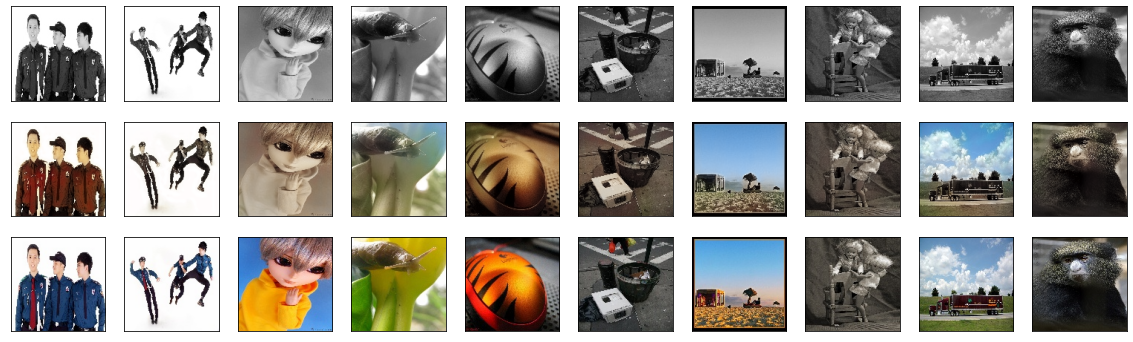

In [26]:
show_images(x_test, y_test_predicted, y_test_real)